<h1> TP6: Generative Adversarial Networks</h1>

Ce TP est consacré à la manipulation de réseaux génératifs exploitant le paradigme d'apprentissage "Adversarial". Ce type de réseaux comprend une partie "Générateur" et une autre "Discriminateur", chacun ayant des objectifs antagonistes. 

La première partie de ce TP illustre la capacité des GAN sur des données artificielles, sous la forme d'un mélange de gaussiennes 1D. Cette partie est fortement guidée et met en évidence la capacité des deux sous réseaux pour parvenir à approcher au mieux la distribution sous jacentes des données.

La deuxième partie nécessite un travail en autonomie. Elle consiste à étendre le réseau préalablement définie pour, cette fois, modéliser la distribution des données issues du jeu de données MNIST (les chiffres manuscrits).

Pour finir, vous pourriez vous amuser et générer des visages réalistes à partir du jeu de données CelebA.

In [2]:
import keras
import keras.backend as K
import numpy as np

<h2>Partie 1: GANs avec des données artificielles</h2>

Dans la cellule suivante, on créé des données artificielles à partir de distributions gaussiennes. Par la suite, on modifiera le code pour obtenir des données multimodales (ie: mélange de gaussinnes).

In [3]:
batch_size = 10
nbdata = 250
data_dim = 1 # 1-dimensional data

xdata = np.random.normal(5, 0.1, (nbdata, data_dim))
#xdata1 = np.random.normal(5, 0.1, (int(nbdata/3), data_dim))
#xdata2 = np.random.normal(10, 0.1, (int(nbdata/3), data_dim)) # for multimodal data
#xdata3 = np.random.normal(15, 0.1, (int(nbdata/3), data_dim)) # for multimodal data
#xdata = np.concatenate((xdata1, xdata2, xdata3), axis=0) # for multimodal data
np.random.shuffle(xdata)


Affichage de la densité de distribution correspondant à nos données :

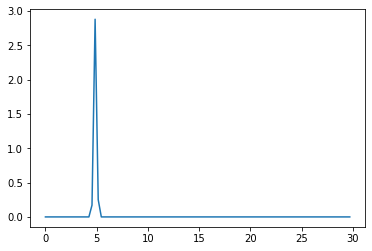

In [4]:
import matplotlib.pyplot as plt

xs = np.linspace(0, 30, 10*batch_size)[:-1]
bins = np.linspace(0, 30, 10*batch_size)
hx,_ = np.histogram(xdata, bins=bins, density=True)
plt.plot(xs, hx)

<h2>Création d'un générateur python pour accéder aux données par batch</h2>

In [5]:
def get_batch():
  i = 0
  while True:
    i = i + batch_size
    if i+batch_size > nbdata: i = 0
    
    yield xdata[i:i+batch_size].reshape((batch_size, data_dim))

data_generator = get_batch()
#x = next(data_generator)
#print(x)

<h2> Création du réseau</h2>

Ici nous créons les deux parties : "générateur" et "discriminateur", puis le modèle combiné "GAN". Réseaux très simples comprenant deux couches cachées denses avec tanh + une couche sortie. Dropout dans le discriminateur.

In [10]:
from tensorflow.keras.optimizers import Adam

# some hyperparameters
z_dim = 5
h_dim = 10

def generator(opt):
  model = keras.models.Sequential()
  model.add(keras.layers.Dense(h_dim, activation="tanh", input_shape=(z_dim,)))
  model.add(keras.layers.Dense(int((h_dim+data_dim)/2), activation="tanh", input_shape=(z_dim,)))
  model.add(keras.layers.Dense(int((h_dim+data_dim)/2), activation="tanh", input_shape=(z_dim,)))
  model.add(keras.layers.Dense(data_dim))
  model.compile(loss="binary_crossentropy", optimizer=opt)
  return model

opt = Adam(learning_rate=0.001, beta_1=0.5, beta_2=0.99)
G = generator(opt)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [11]:
def discriminator(opt):
  model = keras.models.Sequential()
  model.add(keras.layers.Dense(h_dim, activation="tanh", input_shape=(data_dim,)))
  model.add(keras.layers.Dense(int(h_dim/2), activation="tanh"))
  model.add(keras.layers.Dense(int(h_dim/2), activation="tanh"))
  model.add(keras.layers.Dropout(0.4))
  
  model.add(keras.layers.Dense(1, activation="sigmoid"))
  model.compile(loss="binary_crossentropy", optimizer=opt)
  return model

D = discriminator(opt)

In [12]:
def gan(opt):
  D.trainable = False
  GAN = keras.models.Sequential()
  GAN.add(G)
  GAN.add(D)
  GAN.compile(loss="binary_crossentropy", optimizer=opt)
  return GAN

GAN = gan(opt)

<h2>Apprentissage du modèle</h2>

Initialise des structures pour construire des plots

In [13]:
xtab = []
gtab = []
lossDtab = []
lossGtab = []
Dpostab = []
Dnegtab = []
 
epochs_done = 0

Boucle d'apprentissage, alterne entre le discriminateur et le GAN. Enregistre les valeurs de loss du discriminateur (lossD) et du générateur (lossG), et es prédictions du discriminateur pour des exemples positifs (Dpos) et négatifs (Dneg). Conserve l'historique dans des listes pour affichage ultérieur. On enregistre aussi des données obtenues par le générateur à chaque epoch, ces données seront utilisées et animées dans une cellule suivante.

In [ ]:
data_generator = get_batch()
nb_epoch = 1000 #2000
ones = np.ones((batch_size, 1))
zeros = np.zeros((batch_size, 1))
for epoch in range(nb_epoch):
  lossD = []
  lossG = []
  Dpos = []
  Dneg = []
  for batch in range(int(nbdata/batch_size)):
    # train discriminator with positive samples
    x = next(data_generator)
    lossP = D.train_on_batch(x, ones)
    if epoch % 10 == 0:
      x = next(data_generator)
      Dpos.append( D.predict(x) )
    
    # train discriminator with negative samples
    z = np.random.uniform(-1,1,(batch_size, z_dim))
    fakes = G.predict(z)
    lossN = D.train_on_batch(fakes, zeros)
    if epoch % 10 == 0:
      z = np.random.uniform(-1,1,(batch_size, z_dim))
      fakes = G.predict(z)
      Dneg.append( D.predict(fakes) )
    
    # compute D's loss (for plotting)
    lossD.append((lossP + lossN) / 2.)
    
    # train generator with GAN
    z = np.random.uniform(-1,1,(batch_size, z_dim))
    lossG.append( GAN.train_on_batch(z, ones) )
  
  # Compute and store some statistics for further plotting
  if epoch % 10 == 0:
    lossD = np.mean(lossD)
    lossG = np.mean(lossG)
    Dpos = np.mean(Dpos)
    Dneg = np.mean(Dneg)
  
    lossDtab.append(lossD)
    lossGtab.append(lossG)
    Dpostab.append(Dpos)
    Dnegtab.append(Dneg)
  
    print(epoch, " lossD=", lossD, " lossG=", lossG, " Dpos=", Dpos, " Dneg=", Dneg )
  
  # Sample data from generator to plot an animation of learned distribution
  z = np.random.uniform(-1,1,(10*batch_size, z_dim))
  g = G.predict(z)
  hg,_ = np.histogram(g, bins=bins, density=True)
  gtab.append(hg)
  xtab.append(hx)
  
  epochs_done = epochs_done + 1

0  lossD= 0.5930288648605346  lossG= 0.7084615468978882  Dpos= 0.62186956  Dneg= 0.49200812
10  lossD= 0.5398085075616836  lossG= 0.9192053818702698  Dpos= 0.6109112  Dneg= 0.40435627
20  lossD= 0.8095503258705139  lossG= 0.5944685840606689  Dpos= 0.45137456  Dneg= 0.55294573
30  lossD= 0.6563327240943909  lossG= 0.7801731371879578  Dpos= 0.49974954  Dneg= 0.45597273
40  lossD= 0.6650525856018067  lossG= 0.6661829924583436  Dpos= 0.54594344  Dneg= 0.5158094
50  lossD= 0.6912890219688416  lossG= 0.7033195114135742  Dpos= 0.49842995  Dneg= 0.4941855
60  lossD= 0.6904788994789124  lossG= 0.6927333426475525  Dpos= 0.5024468  Dneg= 0.502997
70  lossD= 0.6939481782913208  lossG= 0.6985371923446655  Dpos= 0.499012  Dneg= 0.498026
80  lossD= 0.6930438899993896  lossG= 0.6922775769233703  Dpos= 0.5018464  Dneg= 0.50088286
90  lossD= 0.6951159429550171  lossG= 0.6991577744483948  Dpos= 0.49700925  Dneg= 0.4965747
100  lossD= 0.6920255565643311  lossG= 0.6932205843925476  Dpos= 0.5012281  Dneg= 0

<h2>Création et affichage des plots</h2>


<b>1. Evolution des prédictions du discriminateur sur les données réelles (en bleu) ou sur les données fournies par le générateur (en vert).</b>
On observe une convergence rapide vers 0.5, le point d'équilibre lorsque le discriminateur ne sait plus distinguer l'origine des données.

In [ ]:
ppos, = plt.plot(Dpostab, label="pos")
pneg, = plt.plot(Dnegtab, label="neg")
plt.legend(handles=[ppos, pneg])

<b>2. Evolution des données obtenues au cours de l'apprentissage.</b>
Selon le nombre d'epochs, la cellule suivante prend un peu de temps pour construire un gif que nous affichons dans la foulée. Cette étape nécessite l'installation du package ffmeg-python.

In [ ]:
#!pip install ffmpeg-python

import matplotlib.pyplot as plt
from matplotlib import animation, rc

fig = plt.figure()
ax = fig.add_subplot(111)

ax.set_xlim((0,30))
ax.set_ylim((0, 4))

px, = ax.plot([], [], lw=2)
pg, = ax.plot([], [], lw=2)

def init():
  px.set_data([],[])
  pg.set_data([],[])
  return (px, pg)

def animate(i):
  px.set_data(xs, xtab[i*10])
  pg.set_data(xs, gtab[i*10])
  return (px, pg)

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=int(epochs_done/10), blit=True)
rc('animation', html='jshtml')
anim


<b>3. Comparaison entre un batch de données original et de données issues du générateur.</b>

In [ ]:
# get a batch of real data (for comparison)
x = next(data_generator)
print("some real data:", x)

# sample some noise then transform them with our generator
z = np.random.uniform(-1,1,(10*batch_size, z_dim))
g = G.predict(z)
print("some generated data", g[:10])

# plot distributions
xs = np.linspace(0, 30, 10*batch_size)[:-1]
bins = np.linspace(0, 30, 10*batch_size)

hg,_ = np.histogram(g, bins=bins, density=True)
plt.plot(xs,hg)

hx,_ = np.histogram(x, bins=bins, density=True)
plt.plot(xs,hx)
plt.show()

# Travail à faire

1. Modifiez la première fonction de création de données pour obtenir la moitiée de données centrées autour de 5 et l'autre autour de 10. La distribution de probabilité associée à ces données est dite "multimodale" (2 modes). 

2. Réinitialisez les modèles et relancez l'apprentissage. Essayez plus d'epoch si besoin. 

3. Augmentez les capacités du discriminateur et générateur en augmentant leur nombre de neurones dans les couches cachées.

4. Augmentez de nouveau le nombre de modes de la distribution de données et retentez l'expérience. La difficulté de parvenir à apprendre des distributions multimodales correspond au "mode collapse" dans la littérature GAN. Une manière de contourner ce problème consiste à encourager le discriminateur à reconnaitre une diversité dans un batch d'exemples. Plusieurs approches ont été proposées dans ce sens, dont "batch discrimination" et "standard deviation discrimination" (à voir dans la littérature).

<h2>Partie 2: GANs sur MNIST</h2>

Cette partie se déroule en totale autonomie.. Une fois bien compris la partie précédente, proposez un réseau adversarial pour générer des chiffres manuscrits (et/ou des visages pour les très motivés). 

Selon la nature et la structure des données, les réseaux "générateur" et "discriminateur" pourront exploiter des couches convolutionnelles, batch_discrimination ou dropout. Attention les couches Batch Discrimination et Dropout se comportent différemment lorsqu'elle sont utilisées en phase d'apprentissage ou d'inférence. Or, le discriminateur utilisé par le modèle combiné "GAN" est en mode "inférence" étant donné qu'il est configuré pour ne pas apprendre. Dans ce cas, avec Keras il est nécessaire de préciser <i>training=True</i> à l'initialisation de ces couches.

Pour MNIST, nous considéront que le générateur prend en entrée un vecteur aléatoire de dimension 10, puis augmentera la taille des représentation jusqu'aux images ciblées (ie 28x28 pour MNIST) par l'emploi successifs de :
- couches Denses de tailles adéquates (ie: 10 - 100 - 400 - 784), en augmentant le nombre de neurones, puis en utilisant la couche Reshape avant la sortie.
- couches Conv2D couplées avec des couches UpSampling ; ou Conv2DTranspose. Toujours en augmentant progressivement la taille des représentation.